In [1]:
import requests
import pandas as pd

url = "https://api.coingecko.com/api/v3/coins/markets"

params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 50,   # pull more so filtering still leaves ~20
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
data = response.json()

df = pd.DataFrame(data)[
    ["market_cap_rank", "symbol", "name", "market_cap", "current_price"]
]

# -----------------------------
# Filters
# -----------------------------

stablecoins = {
    "usdt", "usdc", "busd", "dai", "tusd",
    "usdp", "fdusd", "gusd", "lusd",
    "ust", "ustc", "usdd", "eurc",'usds','usde','bsc-usd','usd1'
}

# normalize text
df["symbol"] = df["symbol"].str.lower()
df["name"] = df["name"].str.lower()

# remove stablecoins
df = df[~df["symbol"].isin(stablecoins)]

# remove wrapped coins
df = df[
    ~df["name"].str.contains("wrapped") &
    ~df["symbol"].str.startswith("w")
]

# take top 20 after filtering
df = df.sort_values("market_cap", ascending=False).head(20)

print(df)


    market_cap_rank      symbol               name     market_cap  \
0                 1         btc            bitcoin  1656215556328   
1                 2         eth           ethereum   329787407563   
3                 4         bnb                bnb   115619096671   
4                 5         xrp                xrp   107073300899   
6                 7         sol             solana    65849185800   
7                 8         trx               tron    27642898293   
8                 9       steth  lido staked ether    26201558284   
9                10        doge           dogecoin    19390897261   
10               11  figr_heloc       figure heloc    15399969964   
11               12         ada            cardano    11941266989   
13               14         bch       bitcoin cash    11057084689   
20               21         leo          leo token     8479999853   
21               22         xmr             monero     8365623249   
22               23        link   

In [2]:
binance_symbols = requests.get(
    "https://api.binance.com/api/v3/exchangeInfo"
).json()

binance_assets = {
    s["baseAsset"].lower()
    for s in binance_symbols["symbols"]
    if s["quoteAsset"] == "USDT"
}

df = df[df["symbol"].isin(binance_assets)]

In [3]:
df

,market_cap_rank,symbol,name,market_cap,current_price
0,1,btc,bitcoin,1656215556328,82861.000000
1,2,eth,ethereum,329787407563,2730.140000
3,4,bnb,bnb,115619096671,847.970000
4,5,xrp,xrp,107073300899,1.760000
6,7,sol,solana,65849185800,116.240000
7,8,trx,tron,27642898293,0.291851
9,10,doge,dogecoin,19390897261,0.115054
11,12,ada,cardano,11941266989,0.324674
13,14,bch,bitcoin cash,11057084689,553.160000
21,22,xmr,monero,8365623249,454.390000


In [ ]:
from binance.client import Client
import datetime
client = Client()


end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=60)

klines_btc = client.get_historical_klines(
    "BTCUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
df_btc = pd.DataFrame(klines_btc, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])
df_btc=df_btc[['timestamp','close']]

klines_eth = client.get_historical_klines(
    "ETHUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
klines_bnb = client.get_historical_klines(
    "BNBUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)

df_btc = pd.DataFrame(klines_btc, columns=['open_time','close'])

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,10,11
0,1764630000000,86572.65000000,86750.00000000,86442.17000000,86449.94000000,138.64627000,1764630899999,12009449.84376210,38086,53.68037000,...,829.57000000,826.89000000,827.36000000,1041.98400000,1764630899999,863054.39976000,10234,428.22000000,354722.24663000,0
1,1764630900000,86449.95000000,86742.72000000,86449.94000000,86742.71000000,85.08354000,1764631799999,7373878.54044470,36464,46.84042000,...,830.07000000,827.35000000,830.06000000,1117.03200000,1764631799999,926266.06735000,5793,673.64300000,558651.68739000,0
2,1764631800000,86742.71000000,86833.55000000,86472.75000000,86509.67000000,207.45033000,1764632699999,17977107.21816660,56002,101.10591000,...,832.32000000,828.90000000,829.80000000,1958.28800000,1764632699999,1626856.17910000,10301,1150.83600000,956125.29935000,0
3,1764632700000,86509.66000000,86509.67000000,86249.80000000,86286.01000000,172.92721000,1764633599999,14936823.83491130,51830,49.16543000,...,829.89000000,826.61000000,826.61000000,1370.80700000,1764633599999,1135830.67144000,9302,433.85300000,359246.19917000,0
4,1764633600000,86286.01000000,86569.17000000,86262.52000000,86316.49000000,214.12193000,1764634499999,18498590.39245140,67260,89.85828000,...,827.42000000,823.83000000,824.09000000,1515.55200000,1764634499999,1251685.55579000,12539,757.76100000,625884.72922000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723,1769780700000,82930.28000000,82930.29000000,82638.00000000,82740.92000000,144.34832000,1769781599999,11945264.41079100,49606,72.46107000,...,848.39000000,843.83000000,845.34000000,1804.54900000,1769781599999,1526017.73274000,12902,628.59400000,531309.12294000,0
5724,1769781600000,82740.93000000,83128.00000000,82738.68000000,82973.37000000,280.15154000,1769782499999,23245061.29275160,73306,179.07088000,...,850.33000000,845.33000000,849.10000000,1758.84400000,1769782499999,1493058.41589000,15261,1109.31500000,941640.92730000,0
5725,1769782500000,82973.38000000,83127.00000000,82944.01000000,82980.00000000,207.28993000,1769783399999,17205594.05379800,64349,103.81734000,...,849.62000000,848.36000000,848.90000000,815.70500000,1769783399999,692593.78640000,8777,389.82800000,331006.35817000,0
5726,1769783400000,82979.99000000,83660.87000000,82784.00000000,83650.86000000,731.07432000,1769784299999,60902923.77086480,224587,448.05960000,...,855.19000000,847.64000000,854.84000000,4646.41400000,1769784299999,3958625.06990000,37605,2580.37300000,2198585.16555000,0


In [18]:
import pandas as pd
from binance.client import Client

def get_close_prices_15m(
    client,
    symbols,
    start_date,
    end_date
):
    """
    Download 15-minute close prices for selected coins.

    Parameters
    ----------
    client : Binance Client
    symbols : list[str]
        Example: ["BTC", "ETH", "BNB", "SOL"]
    start_date : datetime
    end_date : datetime

    Returns
    -------
    pd.DataFrame
        timestamp × coin close prices
    """

    close_dfs = []

    for sym in symbols:
        pair = sym.upper() + "USDT"
        print(f"Downloading {pair}")

        klines = client.get_historical_klines(
            pair,
            Client.KLINE_INTERVAL_15MINUTE,
            start_date.strftime("%d %b %Y %H:%M:%S"),
            end_date.strftime("%d %b %Y %H:%M:%S")
        )

        df = pd.DataFrame(klines, columns=[
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "number_of_trades",
            "taker_buy_base", "taker_buy_quote", "ignore"
        ])

        df = df[["timestamp", "close"]]
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df["close"] = df["close"].astype(float)

        df = df.rename(columns={"close": sym.upper()})

        close_dfs.append(df)

    # ---- merge all coins on timestamp ----
    df_close = close_dfs[0]

    for d in close_dfs[1:]:
        df_close = df_close.merge(
            d,
            on="timestamp",
            how="outer"
        )

    df_close = (
        df_close
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    return df_close


In [24]:

import datetime



#start_date = datetime(2025, 1, 1)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=60)


df_close_15m = get_close_prices_15m(
    client,
    df['symbol'].tolist(),
    start_date,
    end_date
)


Text(0, 0.5, 'Price')

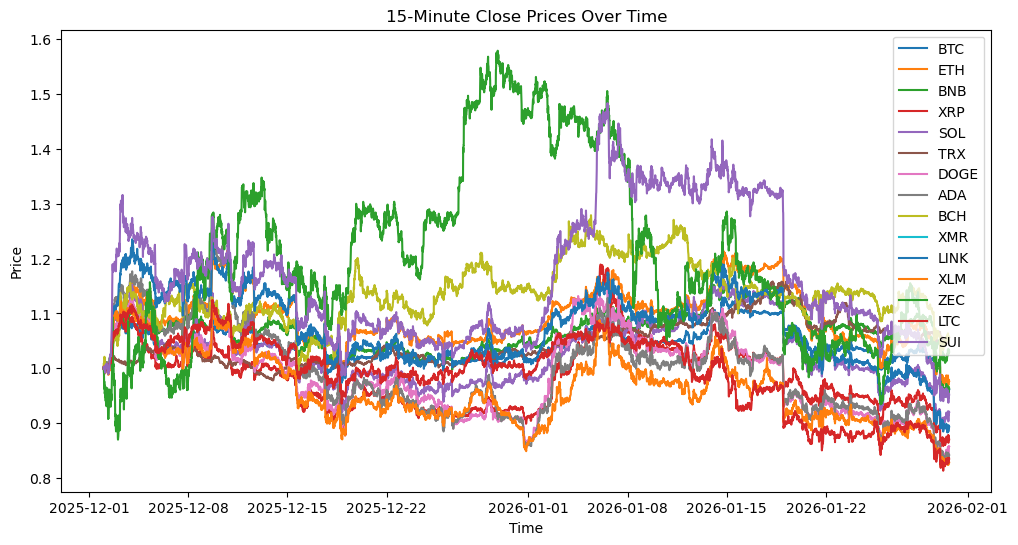

In [28]:
import matplotlib.pyplot as plt

normalized_df = df_close_15m / df_close_15m.iloc[0]  # Normalize to the first row

plt.figure(figsize=(12, 6))
for col in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[col], label=col)
plt.legend()
plt.title("15-Minute Close Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")

In [31]:
normalized_df.head()

,BTC,ETH,BNB,XRP,SOL,TRX,DOGE,ADA,BCH,XMR,LINK,XLM,ZEC,LTC,SUI
timestamp,,,,,,,,,,,,,,,
2025-12-02 00:45:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2025-12-02 01:00:00,1.002979,1.003101,1.004454,1.002919,1.001413,1.003250,1.003613,1.003100,1.008992,NaN,1.002483,1.003000,0.996160,1.002572,1.002742
2025-12-02 01:15:00,1.002595,1.003005,1.004236,1.002226,0.999529,1.002167,1.002138,1.000517,1.007270,NaN,1.000828,1.003429,0.990315,1.000900,0.999704
2025-12-02 01:30:00,1.000470,1.000533,1.003159,1.000742,0.997488,1.002528,1.001548,0.999483,1.009374,NaN,0.998344,1.004286,0.969740,0.998585,1.000741
2025-12-02 01:45:00,0.999325,0.999789,1.003219,0.998170,0.997017,1.001445,1.001032,0.998450,1.017792,NaN,0.996689,0.998714,0.976274,0.997942,0.999481


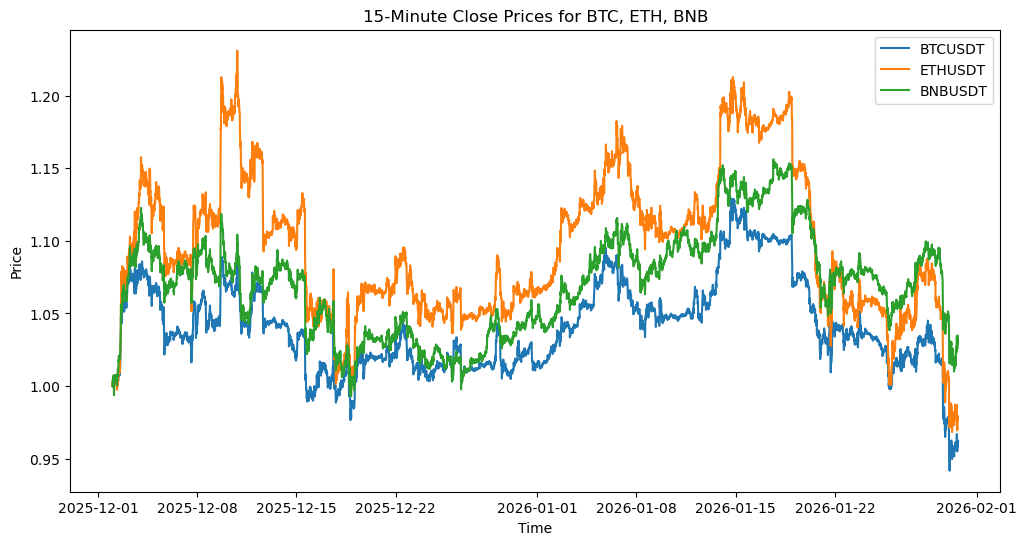

In [32]:
plt.figure(figsize=(12,6))
plt.plot(normalized_df.index, normalized_df['BTC'], label='BTCUSDT')
plt.plot(normalized_df.index, normalized_df['ETH'], label='ETHUSDT')
plt.plot(normalized_df.index, normalized_df['BNB'], label='BNBUSDT')
plt.legend()
plt.title("15-Minute Close Prices for BTC, ETH, BNB")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [40]:
normalized_df.head()
# Drop columns where ALL values are NaN
df_close_15m = df_close_15m.dropna(axis=1, how='all')
normalized_df=normalized_df.dropna(axis=1, how='all')

# Or drop columns with ANY NaN values
#df_close_15m = df_close_15m.dropna(axis=1, how='any')

In [36]:
df_close_15m

,BTC,ETH,BNB,XRP,SOL,TRX,DOGE,ADA,BCH,LINK,XLM,ZEC,LTC,SUI
timestamp,,,,,,,,,,,,,,
2025-12-02 00:45:00,86513.33,2795.68,826.30,2.0214,127.37,0.2769,0.13564,0.3871,522.7,12.08,0.2333,348.98,77.76,1.3493
2025-12-02 01:00:00,86771.05,2804.35,829.98,2.0273,127.55,0.2778,0.13613,0.3883,527.4,12.11,0.2340,347.64,77.96,1.3530
2025-12-02 01:15:00,86737.81,2804.08,829.80,2.0259,127.31,0.2775,0.13593,0.3873,526.5,12.09,0.2341,345.60,77.83,1.3489
2025-12-02 01:30:00,86553.99,2797.17,828.91,2.0229,127.05,0.2776,0.13585,0.3869,527.6,12.06,0.2343,338.42,77.65,1.3503
2025-12-02 01:45:00,86454.93,2795.09,828.96,2.0177,126.99,0.2773,0.13578,0.3865,532.0,12.04,0.2330,340.70,77.60,1.3486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-30 15:30:00,83266.40,2738.34,855.06,1.7748,116.89,0.2913,0.11614,0.3263,553.5,10.83,0.1947,337.38,65.08,1.2852
2026-01-30 15:45:00,82883.94,2729.47,850.11,1.7583,116.80,0.2915,0.11605,0.3257,551.6,10.76,0.1936,336.35,64.82,1.2775
2026-01-30 16:00:00,83071.61,2736.52,852.18,1.7648,117.18,0.2921,0.11647,0.3264,552.0,10.81,0.1940,336.33,64.99,1.2851


In [37]:
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


In [38]:
def test_cointegration(series_x, series_y):
    """
    Engle-Granger 2-step cointegration test
    """

    # 1️⃣ Hedge ratio (OLS)
    X = sm.add_constant(series_x)
    model = sm.OLS(series_y, X).fit()
    beta = model.params[1]

    spread = series_y - beta * series_x

    # 2️⃣ Cointegration test
    score, pvalue, crit = coint(series_y, series_x)

    return {
        "beta": beta,
        "pvalue": pvalue,
        "t_stat": score,
        "crit_1%": crit[0],
        "crit_5%": crit[1],
        "crit_10%": crit[2],
        "spread": spread
    }


In [41]:
results = []

pairs = list(combinations(normalized_df.columns, 2))

for x, y in pairs:
    res = test_cointegration(normalized_df[x], normalized_df[y])

    results.append({
        "pair": f"{x}-{y}",
        "x": x,
        "y": y,
        "beta": res["beta"],
        "pvalue": res["pvalue"],
        "t_stat": res["t_stat"],
        "crit_5%": res["crit_5%"]
    })

df_coint = pd.DataFrame(results)


/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_13604/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_13604/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_13604/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = mo

In [45]:
df_coint[:10]

,pair,x,y,beta,pvalue,t_stat,crit_5%
0,BTC-ETH,BTC,ETH,1.500983,0.029133,-3.538483,-3.337197
1,BTC-BNB,BTC,BNB,1.009446,0.183434,-2.746113,-3.337197
2,BTC-XRP,BTC,XRP,1.498535,0.179822,-2.756787,-3.337197
3,BTC-SOL,BTC,SOL,1.710732,0.019737,-3.674815,-3.337197
4,BTC-TRX,BTC,TRX,0.680435,0.755410,-1.514962,-3.337197
5,BTC-DOGE,BTC,DOGE,1.653454,0.478505,-2.095910,-3.337197
6,BTC-ADA,BTC,ADA,1.655631,0.640590,-1.777490,-3.337197
7,BTC-BCH,BTC,BCH,0.687003,0.124165,-2.943843,-3.337197
8,BTC-LINK,BTC,LINK,1.694075,0.810867,-1.360086,-3.337197
9,BTC-XLM,BTC,XLM,1.262281,0.509020,-2.037535,-3.337197


In [43]:
coint_pairs = df_coint[df_coint["pvalue"] < 0.05]
coint_pairs = coint_pairs.sort_values("pvalue")
coint_pairs

,pair,x,y,beta,pvalue,t_stat,crit_5%
81,LINK-XLM,LINK,XLM,0.856659,0.002185,-4.343912,-3.337197
72,ADA-XLM,ADA,XLM,0.755992,0.002216,-4.339985,-3.337197
45,XRP-SUI,XRP,SUI,1.815935,0.010430,-3.884166,-3.337197
54,SOL-SUI,SOL,SUI,1.884976,0.019211,-3.684016,-3.337197
3,BTC-SOL,BTC,SOL,1.710732,0.019737,-3.674815,-3.337197
0,BTC-ETH,BTC,ETH,1.500983,0.029133,-3.538483,-3.337197
40,XRP-BCH,XRP,BCH,0.393276,0.048182,-3.350270,-3.337197
